<a href="https://colab.research.google.com/github/AndreyDyachkov/Data_analytics_with_Python/blob/main/09_mobile_app_sales_analysis/Online_food_store_sales_funnel_A_A_B_tests_(Yandex).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online food store sales funnel analysis. A/A/B tests (Yandex)

<b>Task:</b>
Understand user behaviour in a startup mobile application that sells food:
1. Explore the sales funnel: how users reach the purchase; how many users reach the purchase; how much gets stuck in the previous steps? Which ones exactly?
2. Examine the results of the A/A/B font replacement experiment and find out which font is better (2 control groups with old fonts and 1 experimental group with new ones).

<b>Data description: </b>
Table logs_exp.csv - Each entry in the log is a user action, or event.
- EventName — event name;
- DeviceIDHash — unique user ID;
- EventTimestamp — event time;
- ExpId is the number of the experiment: 246 and 247 are the control groups, and 248 is the experimental group.

### Stage 1. Getting data

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import math as mth
from scipy import stats as st

import matplotlib.pyplot as plt
from plotly import graph_objects as go

#### Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y_Praktikum/data/logs_exp.csv')
df.head()

,EventName\tDeviceIDHash\tEventTimestamp\tExpId
0,MainScreenAppear\t4575588528974610257\t1564029...
1,MainScreenAppear\t7416695313311560658\t1564053...
2,PaymentScreenSuccessful\t3518123091307005509\t...
3,CartScreenAppear\t3518123091307005509\t1564054...
4,PaymentScreenSuccessful\t6217807653094995999\t...


Changing the delimiter to "/t"

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y_Praktikum/data/logs_exp.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Stage 2. Data processing

#### Changing column names

In [5]:
#df.columns = ['event_name','user_id','event_time_stamp','exp_id']
#df.head()

Alternative

In [6]:
df.rename(columns = {'EventName':'event_name'
                     ,'DeviceIDHash':'user_id'
                     ,'EventTimestamp':'event_time_stamp'
                     ,'ExpId':'exp_id'}
          , inplace = True)
df.head()

,event_name,user_id,event_time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


#### Checking for duplicates, missing values, wrong data types 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   event_name        244126 non-null  object
 1   user_id           244126 non-null  int64 
 2   event_time_stamp  244126 non-null  int64 
 3   exp_id            244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


There is no missing values or wrong data types. Event_time_stamp column has a unix time format.

In [8]:
df.duplicated().sum()

413

We found 413 duplicates, let's remove them.

In [9]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

#### Adding a date column and a date and time column

In [10]:
df['event_datetime']= pd.to_datetime(df['event_time_stamp'], unit='s')
df.head()

,event_name,user_id,event_time_stamp,exp_id,event_datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [11]:
#df['event_date']= df['event_datetime'].dt.normalize()
#df.head()

In [12]:
df['event_date'] = df['event_datetime'].dt.floor('1D')
df.head()

,event_name,user_id,event_time_stamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Stage 3. EDA

#### Total number of events in the log

One row = one event. Total number of events:

In [13]:
len(df)

243713

Let's also look at the names of the events:

In [14]:
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

We can already see the funnel: the main screen - the cart screen - the payment. Offer screen could be also included in the funnel. Few people watch the tutorial, so it's definitely not in a funnel.

#### Total number of users in the log

In [15]:
df['user_id'].nunique()

7551

The log has 7551 users

#### Average number of events per user

In [16]:
len(df) / df['user_id'].nunique()

32.27559263673685

32 events on average. Let's look at the descriptive statistics

In [17]:
df.groupby('user_id')['user_id'].count().describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: user_id, dtype: float64

The maximum value is very high. The mean is much higher than the median. Probably there is a rigth-skewed distribution. Let's look

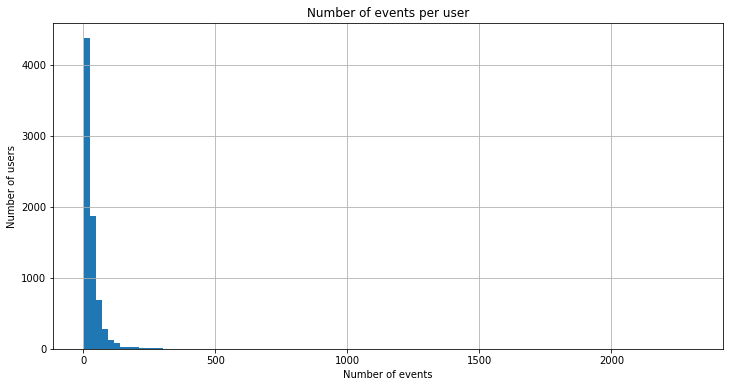

In [18]:
df.groupby('user_id')['user_id'].count().hist(bins=100, figsize=(12,6))
plt.title('Number of events per user')
plt.xlabel('Number of events')
plt.ylabel('Number of users')
plt.show()

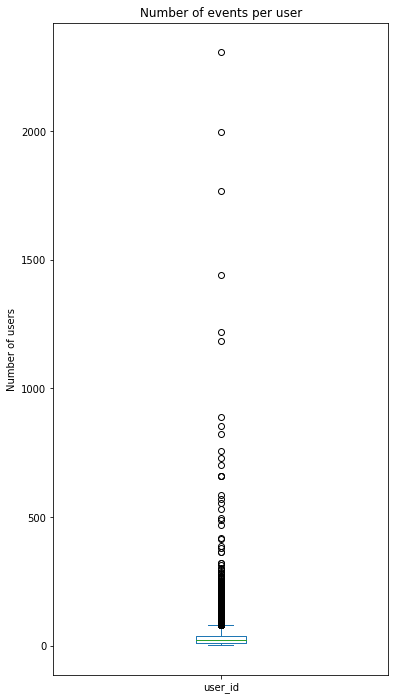

In [19]:
df.groupby('user_id')['user_id'].count().plot(kind='box', figsize=(6,12))
plt.title('Number of events per user')
plt.ylabel('Number of users')
plt.show()

Let's check users with the maximum number of events

In [20]:
df.groupby('user_id')['user_id'].count().sort_values(ascending=False).head(5)

user_id
6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
Name: user_id, dtype: int64

In [21]:
df[df['user_id']==6304868067479728361].head(50).sort_values(by='event_datetime')

,event_name,user_id,event_time_stamp,exp_id,event_datetime,event_date
32882,MainScreenAppear,6304868067479728361,1564682485,248,2019-08-01 18:01:25,2019-08-01
32893,CartScreenAppear,6304868067479728361,1564682503,248,2019-08-01 18:01:43,2019-08-01
32894,PaymentScreenSuccessful,6304868067479728361,1564682503,248,2019-08-01 18:01:43,2019-08-01
32896,MainScreenAppear,6304868067479728361,1564682504,248,2019-08-01 18:01:44,2019-08-01
32897,OffersScreenAppear,6304868067479728361,1564682512,248,2019-08-01 18:01:52,2019-08-01
32905,OffersScreenAppear,6304868067479728361,1564682526,248,2019-08-01 18:02:06,2019-08-01
32961,OffersScreenAppear,6304868067479728361,1564682655,248,2019-08-01 18:04:15,2019-08-01
32964,PaymentScreenSuccessful,6304868067479728361,1564682659,248,2019-08-01 18:04:19,2019-08-01
32965,CartScreenAppear,6304868067479728361,1564682659,248,2019-08-01 18:04:19,2019-08-01
32981,PaymentScreenSuccessful,6304868067479728361,1564682692,248,2019-08-01 18:04:52,2019-08-01


Too many purchases per user. Perhaps these are technical errors in assigning id to users.

<b>Results:</b> On average, there are 32 events per user, median 20, distribution is right-skewed. There are outliers, users with a very large number of events

#### Checking the period we have data for

In [22]:
df['event_date'].describe(datetime_is_numeric=True)

count                           243713
mean     2019-08-03 21:33:56.735012096
min                2019-07-25 00:00:00
25%                2019-08-02 00:00:00
50%                2019-08-04 00:00:00
75%                2019-08-06 00:00:00
max                2019-08-07 00:00:00
Name: event_date, dtype: object

A 14-day period, from 07/25/2019 to 08/07/2019 inclusive

Number of events per date and time

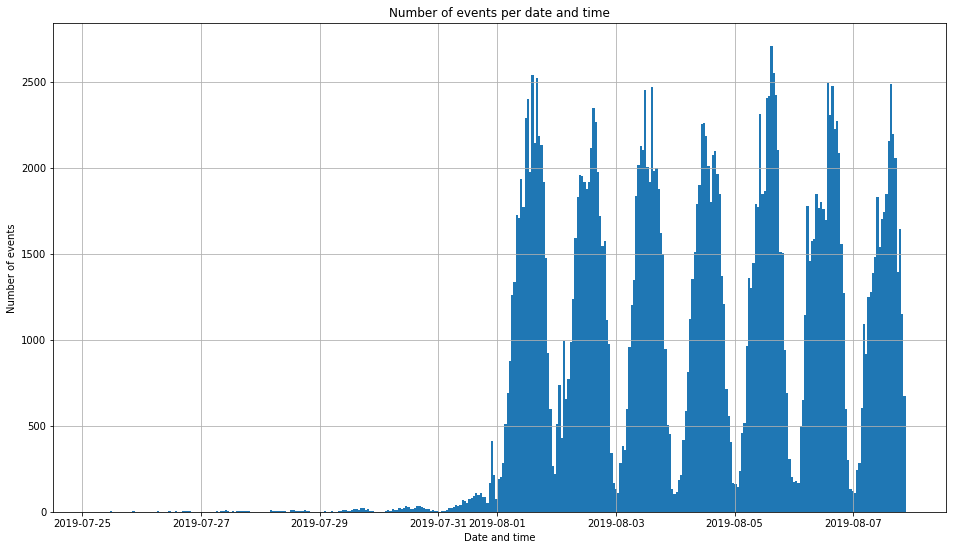

In [23]:
df['event_datetime'].hist(bins = 360, figsize=(16,9))
plt.title('Number of events per date and time')
plt.xlabel('Date and time')
plt.ylabel('Number of events')
plt.show()

In [24]:
df['event_date'].value_counts().sort_index()

2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event_date, dtype: int64

There is much less data until 2019-08-01. It could be a technical error or the service was practically not used. It makes sense to take only August from the 1st to the 7th. Let's create a dataset with these dates

In [25]:
df_fixed = df.query('event_date >= "2019-08-01"')
df_fixed.head()

,event_name,user_id,event_time_stamp,exp_id,event_datetime,event_date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [26]:
df_fixed['event_date'].describe(datetime_is_numeric=True)

count                           240887
mean     2019-08-03 22:48:55.002718976
min                2019-08-01 00:00:00
25%                2019-08-02 00:00:00
50%                2019-08-04 00:00:00
75%                2019-08-06 00:00:00
max                2019-08-07 00:00:00
Name: event_date, dtype: object

So we have a 7-day period

Number of events we lost:

In [27]:
len(df_fixed) - len(df)

-2826

In [28]:
len(df_fixed) / len(df) -1 

-0.01159560630741896

We lost as little as 1.2%

Lost users:

In [29]:
df_fixed['user_id'].nunique() - df['user_id'].nunique()

-17

In [30]:
df_fixed['user_id'].nunique() / df['user_id'].nunique() -1

-0.0022513574361011646

We lost only 0.2% of the total number of users

<b>Results:</b> we did not lose a significant number of events and users by trimming the dataset

#### Checking the distribution of users among groups

In [31]:
df_fixed.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Let's check the uniqueness of users in each group. There should not be users assigned to 2 or more groups

In [32]:
t = df_fixed.groupby('user_id')['exp_id'].nunique().reset_index()
t[t['exp_id']>1]

,user_id,exp_id


Users are grouped correctly

### Stage 4. Funnel analysis

Event log

In [33]:
df_fixed['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

MainScreenAppear is the most frequent event, which is logical. Tutorial is the rarest, which is also logical, few people read it. The number of successful payments (PaymentScreenSuccessful) is less than the number of cart screens (CartScreenAppear).

Let's count how many users did each of these events and calculate the proportion of users who have made an event at least once.

In [34]:
t = df_fixed.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
t['user_id%'] = ((t['user_id'] / df_fixed['user_id'].nunique())*100).round(2)
t

,event_name,user_id,user_id%
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


The distribution of unique users by event type corresponds to the distribution of event frequency: MainScreenAppear is the most popular screen among users. Tutorial is the rarest. There are fewer successful payments (PaymentScreenSuccessful) than cart screens (CartScreenAppear).

The order of events

The funnel will look like: MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful. Tutorial should not be included in the funnel.

Using the funnel of events, let's calculate the percentage of users who go to the next step of the funnel (from the number of users on the previous one)

We create a table with conversion rates for 4 funnel events and add the first stage with the total number of users

In [35]:
target_events = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']

funnel = df_fixed.query('event_name in @target_events').groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
funnel

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [36]:
new_row = {'event_name':'FirstStage', 'user_id':df_fixed['user_id'].nunique()}
funnel = funnel.append(new_row, ignore_index=True).sort_values(by='user_id', ascending=False).reset_index()
funnel

,index,event_name,user_id
0,4,FirstStage,7534
1,0,MainScreenAppear,7419
2,1,OffersScreenAppear,4593
3,2,CartScreenAppear,3734
4,3,PaymentScreenSuccessful,3539


In [37]:
funnel['final_conversion%'] = (funnel['user_id'] / funnel['user_id'].max() * 100).round(2)
funnel['next_step_conversion%'] = ((funnel['user_id'].pct_change()+1) * 100).round(2)

In [38]:
funnel

,index,event_name,user_id,final_conversion%,next_step_conversion%
0,4,FirstStage,7534,100.00,NaN
1,0,MainScreenAppear,7419,98.47,98.47
2,1,OffersScreenAppear,4593,60.96,61.91
3,2,CartScreenAppear,3734,49.56,81.30
4,3,PaymentScreenSuccessful,3539,46.97,94.78


Let's draw a graph

In [39]:
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['user_id']))

fig.update_layout(
    title={
        'text': "Online food store funnel",
        'y':0.9,
        'x':0.5})

fig.show()

<b>Results:</b> According to the funnel: 98.5% of users see the Main screen. 61.9% of them go to the Offer screen - this is 61% of all users. Next, Cart screen is seen by 81.3% of users who have seen Offer screen - this is 49.6% of all users. Successful payment are made by 94.8% of the number of users who visited Cart screen - this is 47% of the total number of users.

Most of the users were lost on the transition between the Main screen and the Offer screen.
The proportion of users successfully completes the payment: 46.97%.

### Stage 5. Examining the results of the experiment

#### Checking users in each group

In [40]:
users = df_fixed.groupby('exp_id')['user_id'].nunique().reset_index()
users

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


In the experimental group, we have 2537 users, in the two control groups a little less.

#### A/A test

Let's create a pivot table with the number of users for each event in each group

In [41]:
ab_test_table = df_fixed[df_fixed['event_name'].isin(target_events)].groupby(['event_name','exp_id'])['user_id'].nunique().reset_index()
ab_test_table

,event_name,exp_id,user_id
0,CartScreenAppear,246,1266
1,CartScreenAppear,247,1238
2,CartScreenAppear,248,1230
3,MainScreenAppear,246,2450
4,MainScreenAppear,247,2476
5,MainScreenAppear,248,2493
6,OffersScreenAppear,246,1542
7,OffersScreenAppear,247,1520
8,OffersScreenAppear,248,1531
9,PaymentScreenSuccessful,246,1200


The number of users in each group we have already calculated earlier

In [42]:
users

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


Let's create a function whose input will be the name of the event and the names of the groups to compare. We will also add the posibility to set a different level of statistical significance.
<br>
We will use the z test. Null hypothesis: The shares of unique visitors who visited the step of the funnel are the same in the two groups. Alternative hypothesis: there is a significant difference between the shares of unique visitors who visited the step of the funnel.

In [43]:
def a_b_test(event, group1, group2, alpha):
    
    s1 = ab_test_table[(ab_test_table['event_name']==event)&(ab_test_table['exp_id']==group1)]['user_id'].iloc[0]
    s2 = ab_test_table[(ab_test_table['event_name']==event)&(ab_test_table['exp_id']==group2)]['user_id'].iloc[0] 
    t1 = users[users['exp_id']==group1]['user_id'].iloc[0]
    t2 = users[users['exp_id']==group2]['user_id'].iloc[0]
        
    alpha = alpha # significance level
    
    successes = np.array([s1, s2])
    trials = np.array([t1, t2])
    
    p1 = successes[0]/trials[0] # proportion of successes in the first group
    p2 = successes[1]/trials[1] # proportion of successes in the second group
    print('share of users who made an event in the group {}: {:.2%}'.format(group1, p1))
    print('share of users who made an event in the group {}: {:.2%}'.format(group2, p2))
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) # proportion of successes in the combined dataset
    difference = p1 - p2  # difference in proportions in datasets
    print('the difference in the shares of users who made the event: {:.2%}'.format(difference))
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1])) # calculating statistics in standard deviations of the standard normal distribution
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 # set the standard normal distribution (mean 0, standard deviation 1)
    print('p-valueе: ', p_value)

    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the groups')
    else:
        print('We cannot reject the null hypothesis, there is no statistically significant difference between the groups') 

We will calculate the proportion of users who made this event in each of the control groups and check whether the difference between groups is statistically significant.

The most popular event is MainScreenAppear.

In [44]:
ab_test_table[(ab_test_table['event_name']=='MainScreenAppear')&(ab_test_table['exp_id']!=248)]

,event_name,exp_id,user_id
3,MainScreenAppear,246,2450
4,MainScreenAppear,247,2476


The number of users having this event: 2450 and 2476 respectively.

We will use a function and check all events in the cycle. Events have already been written in target_events.

In [45]:
group1 = 246
group2 = 247
alpha = 0.05

for i in target_events:
    print (i)
    a_b_test(i, group1, group2, alpha)
    print()

MainScreenAppear
share of users who made an event in the group 246: 98.63%
share of users who made an event in the group 247: 98.53%
the difference in the shares of users who made the event: 0.10%
p-valueе:  0.7570597232046099
We cannot reject the null hypothesis, there is no statistically significant difference between the groups

OffersScreenAppear
share of users who made an event in the group 246: 62.08%
share of users who made an event in the group 247: 60.49%
the difference in the shares of users who made the event: 1.59%
p-valueе:  0.2480954578522181
We cannot reject the null hypothesis, there is no statistically significant difference between the groups

CartScreenAppear
share of users who made an event in the group 246: 50.97%
share of users who made an event in the group 247: 49.26%
the difference in the shares of users who made the event: 1.70%
p-valueе:  0.22883372237997213
We cannot reject the null hypothesis, there is no statistically significant difference between the gro

<b>Results:</b> There are no significant differences in conversion rates (differences between the shares of unique visitors who visited the 4 stages of the funnel) between the control groups. Therefore, the grouping is correct.

#### A/B tests

##### Comparing the results with each of the control groups separately for each event.

Let's use our function. We compare group 248 and group 246. Since we have planned multiple comparisons (experimental group vs control 1; experimental group vs control 2; experimental group vs control 3 (which consists of control 1 and 2) we apply the Bonferroni correction. (If we do not consider the Tutorial event and rely on the fact that comparing groups A1 + A2 and B will not give anything new, then we have 4 * 3 = 12 checks in total.

In [46]:
group1 = 248
group2 = 246
alpha = 0.05/12

for i in target_events:
    print (i)
    a_b_test(i, group1, group2, alpha)
    print()

MainScreenAppear
share of users who made an event in the group 248: 98.27%
share of users who made an event in the group 246: 98.63%
the difference in the shares of users who made the event: -0.37%
p-valueе:  0.2949721933554552
We cannot reject the null hypothesis, there is no statistically significant difference between the groups

OffersScreenAppear
share of users who made an event in the group 248: 60.35%
share of users who made an event in the group 246: 62.08%
the difference in the shares of users who made the event: -1.73%
p-valueе:  0.20836205402738917
We cannot reject the null hypothesis, there is no statistically significant difference between the groups

CartScreenAppear
share of users who made an event in the group 248: 48.48%
share of users who made an event in the group 246: 50.97%
the difference in the shares of users who made the event: -2.48%
p-valueе:  0.07842923237520116
We cannot reject the null hypothesis, there is no statistically significant difference between the

<b>Results:</b> There are no significant differences in the conversion rate (differences between the proportions of unique visitors who visited the 4 stages of the funnel) between groups 248 and 246.

Comparing group 248 with group 247

In [47]:
group1 = 248
group2 = 247
alpha = 0.05/12

for i in target_events:
    print (i)
    a_b_test(i, group1, group2, alpha)
    print()

MainScreenAppear
share of users who made an event in the group 248: 98.27%
share of users who made an event in the group 247: 98.53%
the difference in the shares of users who made the event: -0.26%
p-valueе:  0.4587053616621515
We cannot reject the null hypothesis, there is no statistically significant difference between the groups

OffersScreenAppear
share of users who made an event in the group 248: 60.35%
share of users who made an event in the group 247: 60.49%
the difference in the shares of users who made the event: -0.14%
p-valueе:  0.9197817830592261
We cannot reject the null hypothesis, there is no statistically significant difference between the groups

CartScreenAppear
share of users who made an event in the group 248: 48.48%
share of users who made an event in the group 247: 49.26%
the difference in the shares of users who made the event: -0.78%
p-valueе:  0.5786197879539783
We cannot reject the null hypothesis, there is no statistically significant difference between the g

<b>Results:</b> There are no significant differences in the conversion rate between 248 and 247 groups.

##### Comparing results with a combined control group.

Let's add the combined group 246-247 to the ab_test_table

In [48]:
control_groups = ab_test_table[ab_test_table['exp_id']!=248]
control_groups

,event_name,exp_id,user_id
0,CartScreenAppear,246,1266
1,CartScreenAppear,247,1238
3,MainScreenAppear,246,2450
4,MainScreenAppear,247,2476
6,OffersScreenAppear,246,1542
7,OffersScreenAppear,247,1520
9,PaymentScreenSuccessful,246,1200
10,PaymentScreenSuccessful,247,1158


In [49]:
control_groups['exp_id'] = control_groups['exp_id'].astype('str')

<ipython-input-49-6fe5bc1516a1>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
control_groups = control_groups.groupby('event_name').agg({'user_id':'sum','exp_id':lambda x: '_'.join(x)}).reset_index()
control_groups

,event_name,user_id,exp_id
0,CartScreenAppear,2504,246_247
1,MainScreenAppear,4926,246_247
2,OffersScreenAppear,3062,246_247
3,PaymentScreenSuccessful,2358,246_247


In [51]:
ab_test_table = ab_test_table.append(control_groups, sort=False)
ab_test_table

,event_name,exp_id,user_id
0,CartScreenAppear,246,1266
1,CartScreenAppear,247,1238
2,CartScreenAppear,248,1230
3,MainScreenAppear,246,2450
4,MainScreenAppear,247,2476
5,MainScreenAppear,248,2493
6,OffersScreenAppear,246,1542
7,OffersScreenAppear,247,1520
8,OffersScreenAppear,248,1531
9,PaymentScreenSuccessful,246,1200


In [52]:
new_row = {'exp_id':'246_247', 'user_id':4997}
users = users.append(new_row, ignore_index=True)
users

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537
3,246_247,4997


Let's compare 248 and the combined control group

In [53]:
group1 = 248
group2 = '246_247'
alpha = 0.05/12

for i in target_events:
    print (i)
    a_b_test(i, group1, group2, alpha)
    print()

MainScreenAppear
share of users who made an event in the group 248: 98.27%
share of users who made an event in the group 246_247: 98.58%
the difference in the shares of users who made the event: -0.31%
p-valueе:  0.29424526837179577
We cannot reject the null hypothesis, there is no statistically significant difference between the groups

OffersScreenAppear
share of users who made an event in the group 248: 60.35%
share of users who made an event in the group 246_247: 61.28%
the difference in the shares of users who made the event: -0.93%
p-valueе:  0.43425549655188256
We cannot reject the null hypothesis, there is no statistically significant difference between the groups

CartScreenAppear
share of users who made an event in the group 248: 48.48%
share of users who made an event in the group 246_247: 50.11%
the difference in the shares of users who made the event: -1.63%
p-valueе:  0.18175875284404386
We cannot reject the null hypothesis, there is no statistically significant differenc

<b>Results:</b> There are no significant differences in conversion rates between the 248 group and the combined control group.

### Conclusion

- We analyzed the event funnel based on entries in the user event log from 07/25/2019 to 08/07/2019. For further analysis, we chose the period from 08/01/2019 to 08/07/2019, because for earlier dates, the number of records was much less.
- The median number of events per user is 20 (average number of events 32 +/- 65). There are probably errors in the log: users with an unrealistically large number of events (because unique users were used in the funnel calculation - this does not affect the analysis results)
- Calculation performed for the event funnel: main screen -> offer -> cart -> successful payment. The largest number of users is lost when moving from the main screen to offer screen. 98.5% of users saw the main screen. 61% of users saw the offer screen. 49.6% of all users got into the cart screen. Successful payments are made by 47% of the total number of users.
- An AAB test (Bonferroni-adjusted z-test for multiple comparisons) was performed for each of the 4 events to evaluate the differences in conversion before and after the font change. According to the results of the AAB test: the breakdown into groups works correctly (no significant differences were found between the two control groups); There were no statistically significant differences between the experimental (new font) and two control groups. Thus, changing the font does not affect the conversion for these 4 events.